In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from nilearn import plotting

from src import data

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-04-11


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False


if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

## Load data

### Load F-TRACT data

In [3]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
ftract_labels = data.load_ftract_labels(PARCELLATION)

### Load structural (and functional) connectivity data

In [4]:
SC_matrices = []

if PARCELLATION == "DKT":
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ftract_labels,ids_to_delete_in_dkt)
    ED = None

elif PARCELLATION == "MNI-HCP-MMP1":
    labels = data.ftract_compatible_glasser_labels()
    centroids = data.load_glasser_centroids(ftract_labels=ftract_labels)
    ED = data.glasser_roi_distances(ftract_labels=ftract_labels)

    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ftract_labels,ED=ED)

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:307: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_rh",SC_W_M, SC_L_M,np.log(SC_W_M)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:310: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_simple",SC_W_M_mean, SC_L_M_mean,np.log(SC_W_M_mean)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:314: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_dist",SC_W_M_dist, SC_L_M_dist,np.log(SC_W_M_dist)))


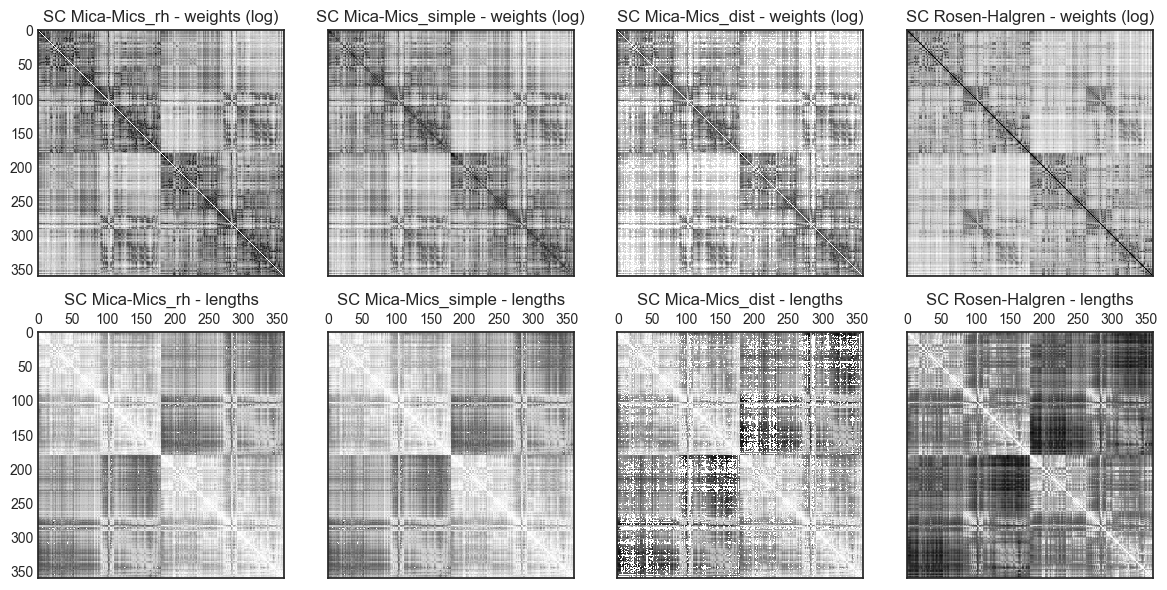

In [5]:
plt.rcParams['figure.figsize'] = [3*number_of_SC,6]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i in range(number_of_SC):
    name, SC_W, SC_L, SC_W_log = SC_matrices[i]

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")

    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

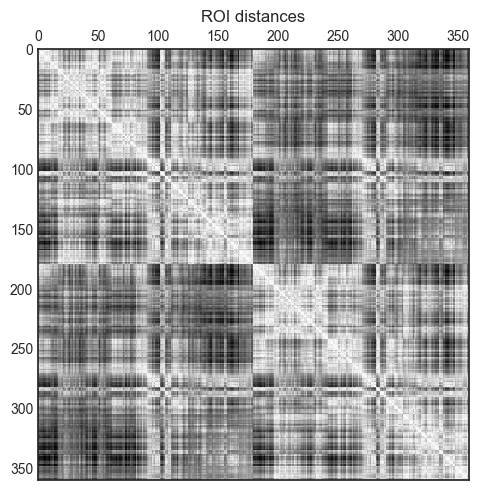

In [6]:
if ED is not None:
    plt.rcParams['figure.figsize'] = [5,5]
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.matshow(ED)
    axs.set_title("ROI distances")

In [7]:
plt.style.use('ggplot')

In [8]:
df_weights = pd.DataFrame()
df_lengths = pd.DataFrame()

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    df_weights[name] = SC_W.flatten()
    if SC_L is not None:
        df_lengths[name] = SC_L.flatten()

In [9]:
pg.pairwise_corr(df_weights,method="spearman")

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,Mica-Mics_rh,Mica-Mics_simple,spearman,two-sided,129600,0.981037,"[0.98, 0.98]",0.0,1.0
1,Mica-Mics_rh,Mica-Mics_dist,spearman,two-sided,129600,0.947689,"[0.95, 0.95]",0.0,1.0
2,Mica-Mics_rh,Rosen-Halgren,spearman,two-sided,129600,0.810489,"[0.81, 0.81]",0.0,1.0
3,Mica-Mics_simple,Mica-Mics_dist,spearman,two-sided,129600,0.970166,"[0.97, 0.97]",0.0,1.0
4,Mica-Mics_simple,Rosen-Halgren,spearman,two-sided,129600,0.818699,"[0.82, 0.82]",0.0,1.0
5,Mica-Mics_dist,Rosen-Halgren,spearman,two-sided,129600,0.798516,"[0.8, 0.8]",0.0,1.0


In [10]:
sns.set_theme(rc={'figure.figsize':(15,7)})

<Axes: ylabel='Probability'>

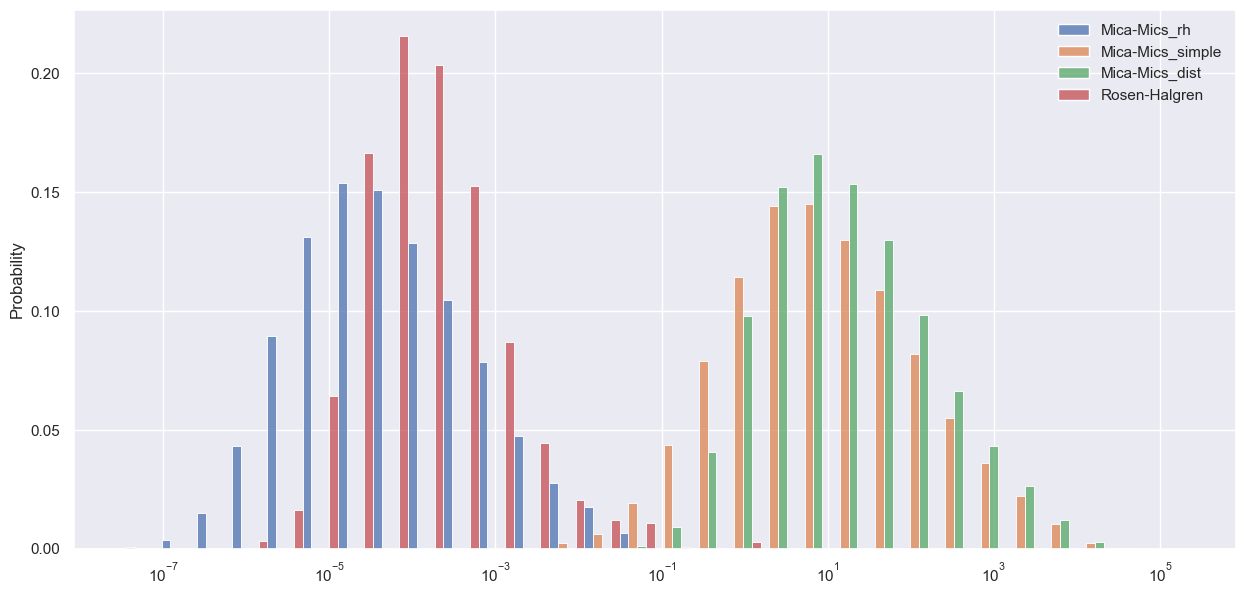

In [11]:
sns.histplot(df_weights,bins=30,log_scale=True,multiple="dodge",stat="probability",common_norm=False)

<Axes: ylabel='Probability'>

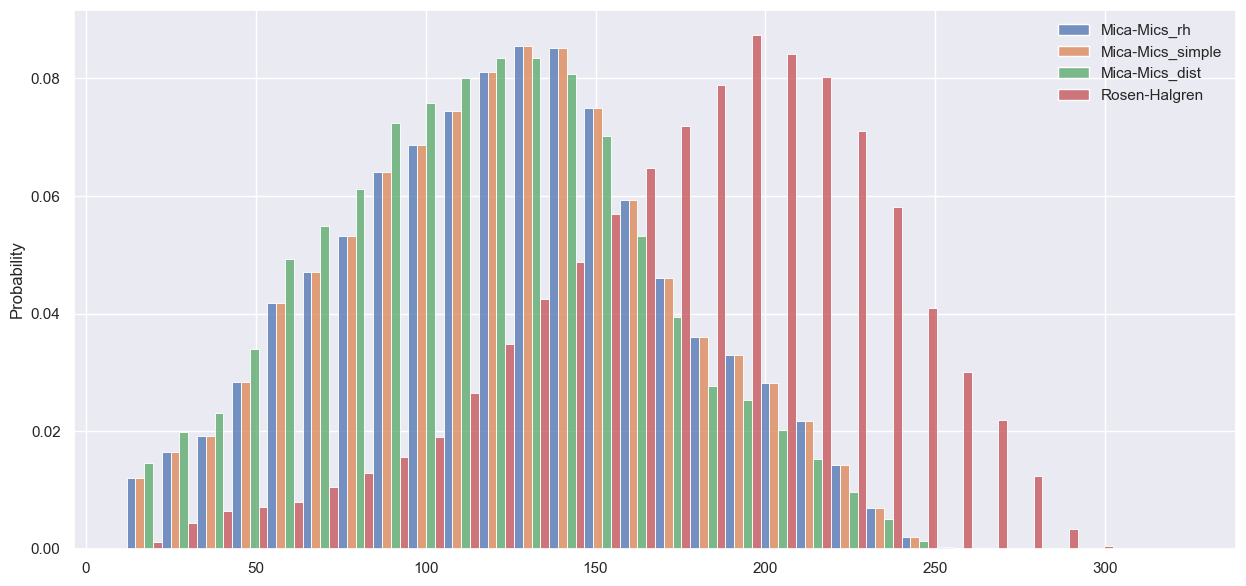

In [12]:
sns.histplot(df_lengths,bins=30,multiple="dodge",stat="probability",common_norm=False)

In [13]:
# the coordinates are not in MNI space, so we shift them manually for plotting reasons
centroids_shifted = centroids
for i in range(3):
    centroids_shifted[:,i] = centroids[:,i] - ((centroids[:,i].max()-centroids[:,i].min())/2+centroids[:,i].min())
centroids_shifted[:,1]-=12
centroids_shifted[:,2]+=15

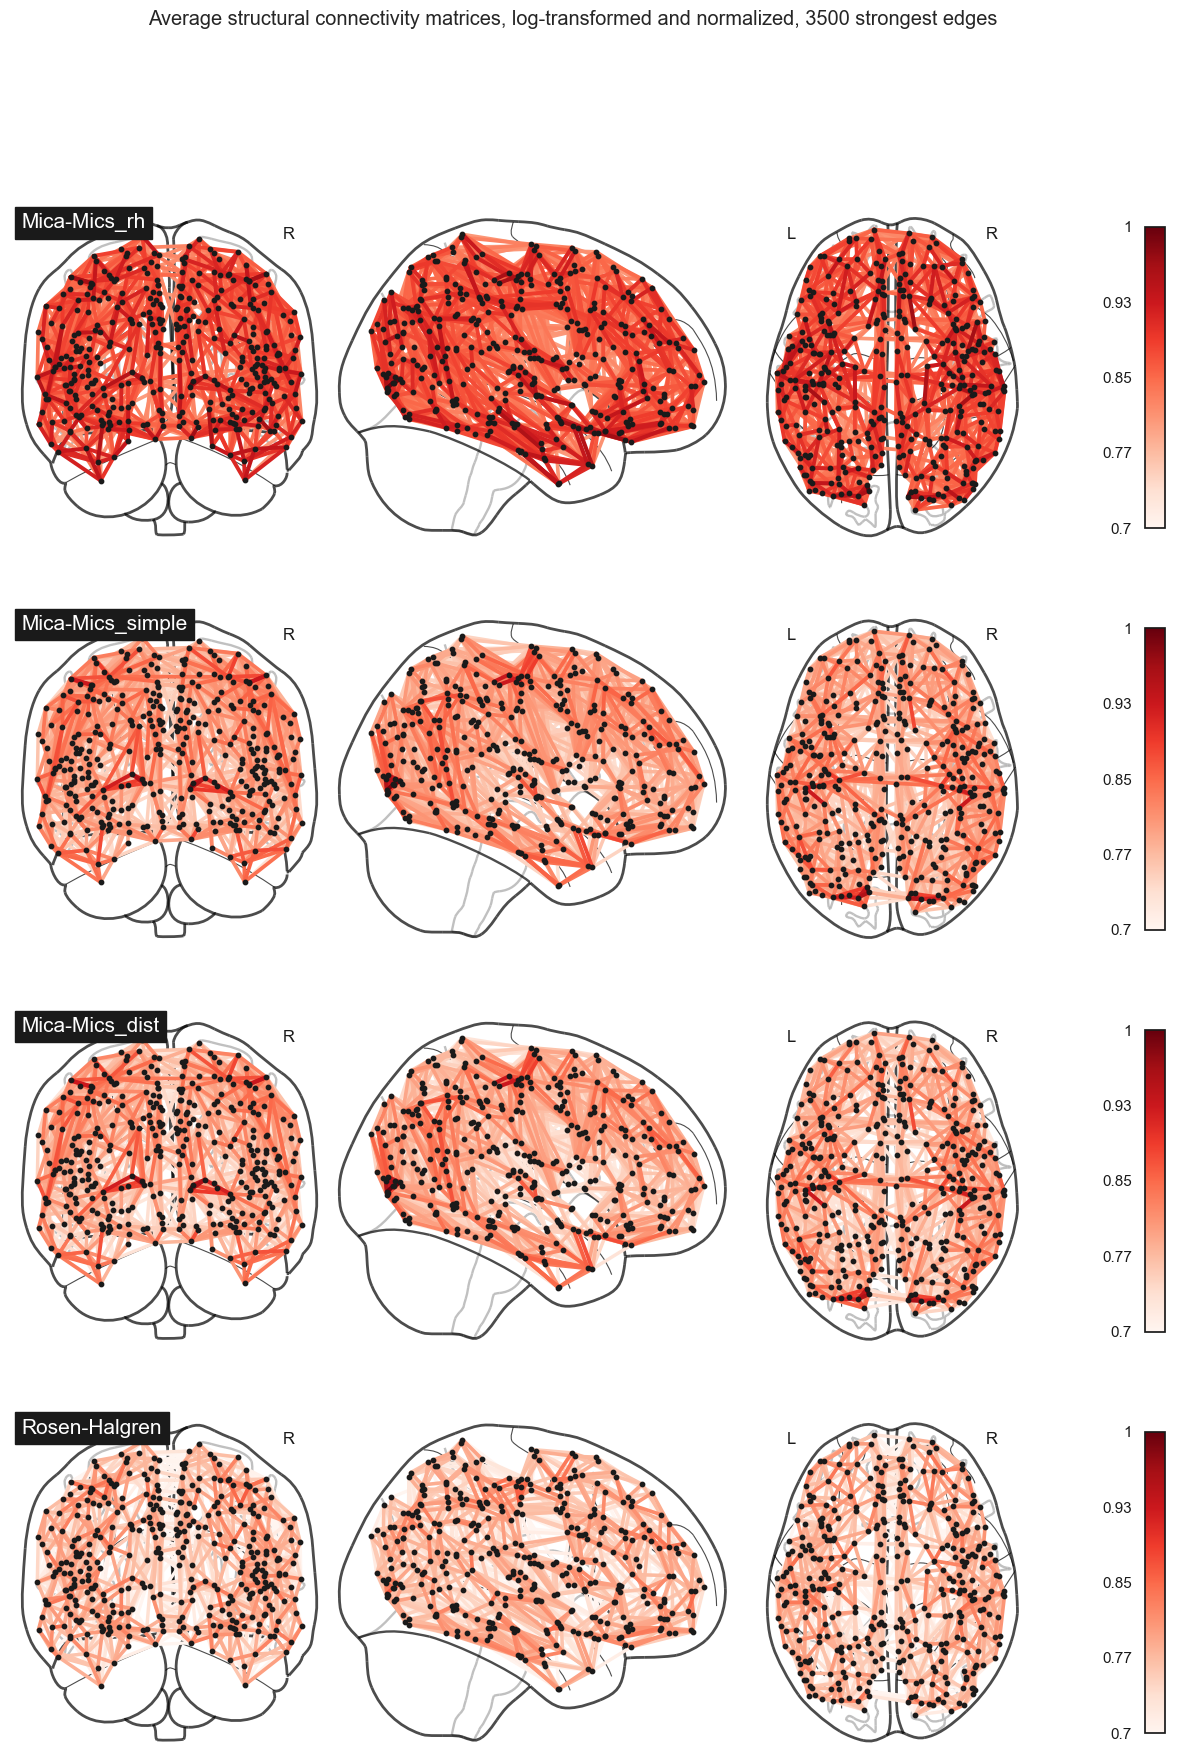

In [24]:
fig, ax= plt.subplots(len(SC_matrices),1,figsize=(15,len(SC_matrices)*5),sharex=True,sharey=True)
n_edges = 3500

fig.suptitle(f"Average structural connectivity matrices, log-transformed and normalized, {n_edges} strongest edges")

for i,d in enumerate(SC_matrices):
    name, SC_W, _, SC_W_log = d
    m = np.nan_to_num(SC_W_log,nan=np.nan,posinf=np.nan,neginf=np.nan)

    m = (m - np.nanmin(m,axis=None))
    m = m/np.nanmax(m,axis=None)

    np.fill_diagonal(m,0)
    pivot = data.find_pivot_to_keep_x_edges(m,x=n_edges)
    m = np.where(m>pivot,m,0)

    plotting.plot_connectome(m,centroids_shifted,axes=ax[i],node_color="k",node_size=10,title=name,colorbar=True,edge_cmap='Reds',edge_vmin=0.7,edge_vmax=1)